In [1]:
# Description: Plot Figure 5 (Monochromatic 2D topography experiments, varying topographic height).
# Author:      André Palóczy
# E-mail:      paloczy@gmail.com
# Date:        March/2022

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from numpy.fft import fft as npfft
from numpy.fft import fft2 as npfft2
from numpy.fft import ifft2 as npifft2
from numpy.fft import fftshift
from hdf5storage import loadmat
from glob import glob
from cmocean.cm import balance
from matplotlib.ticker import FuncFormatter

In [3]:
def near(x, x0, npts=1, return_index=False):
    """
    USAGE
    -----
    xnear = near(x, x0, npts=1, return_index=False)

    Finds 'npts' points (defaults to 1) in array 'x'
    that are closest to a specified 'x0' point.
    If 'return_index' is True (defauts to False),
    then the indices of the closest points are
    returned. The indices are ordered in order of
    closeness.
    """
    x = list(x)
    xnear = []
    xidxs = []
    for n in range(npts):
        idx = np.nanargmin(np.abs(np.array(x)-x0))
        xnear.append(x.pop(idx))
        if return_index:
            xidxs.append(idx)
    if return_index: # Sort indices according to the proximity of wanted points.
        xidxs = [xidxs[i] for i in np.argsort(xnear).tolist()]
    xnear.sort()

    if npts==1:
        xnear = xnear[0]
        if return_index:
            xidxs = xidxs[0]
    else:
        xnear = np.array(xnear)

    if return_index:
        return xidxs
    else:
        return xnear


def normalize_psi(psi1, psi2):
    maxp = 0
    for k in psi1.keys():
        maxpk = np.maximum(np.abs(psi1[k]).max(), np.abs(psi2[k]).max())
        if maxpk>maxp:
            maxp = maxpk

    for k in psi1.keys():
        psi1[k] = psi1[k]/maxp
        psi2[k] = psi2[k]/maxp

    return psi1, psi2


def get_max_psi(psi1, psi2):
    maxp = 0
    for k in psi1.keys():
        maxpk = np.maximum(np.abs(psi1[k]).max(), np.abs(psi2[k]).max())
        if maxpk>maxp:
            maxp = maxpk

    return maxp


def cbfmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    if b==0:
        return r'$0$'
    else:
        return r'${}\times10^{{{}}}$'.format(a, b)


def sech(x):
    return 1/np.cosh(x)

In [4]:
# Baroclinic, upper-layer lateral and topographic energy transfer terms.

def Ethicknessh(psi1, psi2, U1, k, F, dy):
    psi1hx, psi2hx = npfft(psi1, axis=1), npfft(psi2, axis=1)
    eh = 1j*k*F*U1*(psi1hx*psi2hx.conj() - psi1hx.conj()*psi2hx)

    return eh.sum(axis=0)*dy # On LHS.


def Emom1h(psi1, U1, k, l, delta1, dy):
    u1y = npifft2(l**2*npfft2(psi1)).real
    u1yhx = npfft(u1y, axis=1)
    psi1hx = npfft(psi1, axis=1)
    eh = 1j*k*delta1*U1*(psi1hx.conj()*u1yhx - psi1hx*u1yhx.conj())

    return eh.sum(axis=0)*dy # On LHS.


def Etopogh(psi2, h, k, l, delta2, dy):
    psi2h, psi2hx = npfft2(psi2), npfft(psi2, axis=1)
    u = npifft2(-1j*l*psi2h).real
    v = npifft2(+1j*k*psi2h).real
    uhx = npfft(u, axis=1)
    uhhx, vhhx = npfft(u*h, axis=1), npfft(v*h, axis=1)
    eh = -delta2*(uhx.conj()*vhhx + uhx*vhhx.conj() + 1j*k*(psi2hx.conj()*uhhx - psi2hx*uhhx.conj()))

    return eh.sum(axis=0)*dy # On LHS.

In [5]:
plt.close("all")

F1 = 75#25#100
ttyp = "cosi"
# ttyp = "hrand256Km2tk10filtnx32"
# ttyp = "ridg"
NORMALIZE_PSI = True

N = 256
tk = 10
L = 2
U0 = 1
Lj = L/10
dx = L/N
dy = dx
x = np.arange(0, N)
x, y = np.meshgrid(x*dx, x*dx - L/2)
dk = 2*np.pi/L
kp = np.concatenate((np.arange(0, N/2+1), np.arange(-N/2+1, 0)))*dk
k, l = np.meshgrid(kp, kp)
U1 = U0*sech(y/Lj)**2 # Bickley jet
Lh = L/2

# Gather fields from experiments with different topographic heights.
htdimfac = 31.8 # [m]
hts = [1, 5, 10]

htsdim = list(np.array(hts)*htdimfac)
psi1, psi2 = dict(), dict()
Ethh, Em1h, Eth = dict(), dict(), dict()

In [6]:
for ht in hts:
    fname = "../../simulations/lin_N%d_ht%d_F1%d_%s%d.npz"%(N, ht, F1, ttyp, tk)
    if "rand" in ttyp:
        fname_hrand = "../../code_simulations/hrand256Km2tk10filtnx32.mat"
        fname = "../../simulations/lin_N%d_ht%d_F1%d_%s.npz"%(N, ht, F1, ttyp)
    d = np.load(fname)

    p1, p2 = d["p1"], d["p2"]
    psi1.update({"ht-"+str(ht):p1})
    psi2.update({"ht-"+str(ht):p2})

    # Calculate momentum flux and thickness flux spectra.
    d12 = d["d12"].flatten()[0]
    d1 = d12/(1 + d12)
    d2 = 1/(1 + d12)
    F = d1*F1

    # Spectral fluxes on the RHS.
    Ethhi = -Ethicknessh(p1, p2, U1, k, F, dy).real
    Em1hi = -Emom1h(p1, U1, k, l, d1, dy).real
    Ethhi = fftshift(Ethhi); Ethhi = Ethhi[N//2:]
    Em1hi = fftshift(Em1hi); Em1hi = Em1hi[N//2:]

    Ethh.update({"ht-"+str(ht):Ethhi})
    Em1h.update({"ht-"+str(ht):Em1hi})
    if ttyp=='cosi':
        lt = tk*np.pi                          # cosine topography
        kt = lt
        h = ht*np.cos(kt*x)*np.cos(lt*y)
        hy = -lt*ht*np.cos(kt*x)*np.sin(lt*y)
        hx = -kt*ht*np.sin(kt*x)*np.cos(lt*y)
    elif 'rand' in ttyp:                # random topography
        h = loadmat(fname_hrand)["h"]
        h = h*ht*0.5 # ht is rms in random topography. The factor 1/2 is the rms of sin(x)sin(y).
        # hy, hx = np.gradient(h, dx)
        hh = npfft2(h)
        hx = npifft2(1j*k*hh).real
        hy = npifft2(1j*l*hh).real
    elif ttyp=='ridg':
        lt = tk*np.pi                          # ridge topography
        kt = 0
        h = ht*np.cos(lt*y)
        hy = -lt*ht*np.sin(lt*y)
        hx = 0

    Ethi = -Etopogh(p2, h, k, l, d2, dy).real
    Ethi = fftshift(Ethi); Ethi = Ethi[N//2:]
    Eth.update({"ht-"+str(ht):Ethi})

In [7]:
kp = fftshift(k[0, :]); kp = kp[N//2:]

if NORMALIZE_PSI:
    psi1, psi2 = normalize_psi(psi1, psi2) # Normalize psi1 and psi2.
    maxpsi = 1
else:
    maxpsi = get_max_psi(psi1, psi2)
kwclim = dict(vmin=-maxpsi, vmax=maxpsi)

cmap = balance

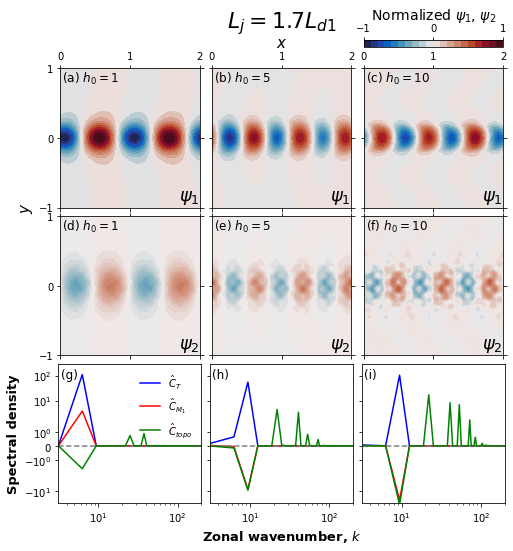

In [8]:
# Plot top and bottom layer streamfunctions for different topographic heights.
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
ax1, ax4, ax7 = ax[0]
ax2, ax5, ax8 = ax[1]
ax3, ax6, ax9 = ax[2]
ax1.xaxis.tick_top(); ax1.xaxis.set_label_position("top")
ax4.xaxis.tick_top(); ax4.xaxis.set_label_position("top")
ax7.xaxis.tick_top(); ax7.xaxis.set_label_position("top")
fig.subplots_adjust(hspace=0.06, wspace=0.06)

ax2.tick_params(labelbottom=False, labelleft=True)
ax4.tick_params(labeltop=True, labelleft=False); ax7.tick_params(labeltop=True, labelleft=False)
ax5.tick_params(labelbottom=False, labelleft=False); ax8.tick_params(labelbottom=False, labelleft=False)
ax3.tick_params(labelbottom=True); ax6.tick_params(labelleft=False); ax9.tick_params(labelbottom=True, labelleft=False)

nlevs = 20
kwcc = dict(levels=nlevs, **kwclim, cmap=cmap)
carr = np.linspace(-maxpsi, maxpsi, num=nlevs)
cs1 = ax1.contourf(x, y, psi1["ht-%s"%hts[0]], **kwcc); ax1.axis("square"); cs1.set_array(carr)
cs2 = ax2.contourf(x, y, psi2["ht-%s"%hts[0]], **kwcc); ax2.axis("square"); cs2.set_array(carr)
cs4 = ax4.contourf(x, y, psi1["ht-%s"%hts[1]], **kwcc); ax4.axis("square"); cs4.set_array(carr)
cs5 = ax5.contourf(x, y, psi2["ht-%s"%hts[1]], **kwcc); ax5.axis("square"); cs5.set_array(carr)
cs7 = ax7.contourf(x, y, psi1["ht-%s"%hts[2]], **kwcc); ax7.axis("square"); cs7.set_array(carr)
cs8 = ax8.contourf(x, y, psi2["ht-%s"%hts[2]], **kwcc); ax8.axis("square"); cs8.set_array(carr)

maxp = []
css = [cs1, cs2, cs4, cs5, cs7, cs8]
for csi in css:
    maxp.append(np.abs(csi.get_array()).max())
cs = css[near(maxp, maxpsi, return_index=True)]

caxx, caxy = 0.0, 1.15
cbaxes = ax7.inset_axes([caxx, caxy, 1.0, 0.05])
if NORMALIZE_PSI:
    cb = fig.colorbar(mappable=cs, cax=cbaxes, orientation="horizontal")
    cblabel = r"Normalized $\psi_1$, $\psi_2$"
else:
    cb = fig.colorbar(mappable=cs, cax=cbaxes, orientation='horizontal', extend='both', format=FuncFormatter(cbfmt))
    cblabel = r"$\psi_1$, $\psi_2$"
cb.ax.xaxis.set_ticks_position("top"); cb.ax.xaxis.set_label_position("top")
cb.set_ticks([-maxpsi, 0, maxpsi])
cb.set_label(cblabel, fontsize=14, fontweight="normal")

xt, yt = 0.015, 0.90
xt2, yt2 = 0.85, 0.05
kwtxt, kwtxt2 = dict(fontsize=12, fontweight="normal"), dict(fontsize=18, fontweight="normal")
ax1.text(xt, yt, r"(a) $h_0 = %d$"%hts[0], transform=ax1.transAxes, **kwtxt)
ax1.text(xt2, yt2, r"$\psi_1$", transform=ax1.transAxes, **kwtxt2)
ax2.text(xt, yt, r"(d) $h_0 = %d$"%hts[0], transform=ax2.transAxes, **kwtxt)
ax2.text(xt2, yt2, r"$\psi_2$", transform=ax2.transAxes, **kwtxt2)
ax3.text(xt, yt, r"(g)", transform=ax3.transAxes, **kwtxt)
ax4.text(xt, yt, r"(b) $h_0 = %d$"%hts[1], transform=ax4.transAxes, **kwtxt)
ax4.text(xt2, yt2, r"$\psi_1$", transform=ax4.transAxes, **kwtxt2)
ax5.text(xt, yt, r"(e) $h_0 = %d$"%hts[1], transform=ax5.transAxes, **kwtxt)
ax5.text(xt2, yt2, r"$\psi_2$", transform=ax5.transAxes, **kwtxt2)
ax6.text(xt, yt, r"(h)", transform=ax6.transAxes, **kwtxt)
ax7.text(xt, yt, r"(c) $h_0 = %d$"%hts[2], transform=ax7.transAxes, **kwtxt)
ax7.text(xt2, yt2, r"$\psi_1$", transform=ax7.transAxes, **kwtxt2)
ax8.text(xt, yt, r"(f) $h_0 = %d$"%hts[2], transform=ax8.transAxes, **kwtxt)
ax8.text(xt2, yt2, r"$\psi_2$", transform=ax8.transAxes, **kwtxt2)
ax9.text(xt, yt, r"(i)", transform=ax9.transAxes, **kwtxt)

eps = kp[1] - kp[0]
kupp = 2e2
ymin, ymax = -3e1, 3e2

# Plot spectra of thickness flux, momentum flux and topographic flux in the bottom row.
ax3.plot(kp, Ethh["ht-%s"%hts[0]], "b", label=r"$\hat{C}_T$")
ax3.plot(kp, Em1h["ht-%s"%hts[0]], "r", label=r"$\hat{C}_{M_1}$")

ax3.set_xscale("log"); ax3.set_yscale("symlog")
ax3.set_xlim(kp[0]+eps, kupp); ax3.set_ylim(ymin, ymax)
ax3.axhline(linestyle="--", color="gray")

ax6.plot(kp, Ethh["ht-%s"%hts[1]], "b")
ax6.plot(kp, Em1h["ht-%s"%hts[1]], "r")
ax6.set_xscale("log"); ax6.set_yscale("symlog")
ax6.set_xlim(kp[0]+eps, kupp); ax6.set_ylim(ymin, ymax)
ax6.axhline(linestyle="--", color="gray")

ax9.plot(kp, Ethh["ht-%s"%hts[2]], "b")
ax9.plot(kp, Em1h["ht-%s"%hts[2]], "r")
ax9.set_xscale("log"); ax9.set_yscale("symlog")
ax9.set_xlim(kp[0]+eps, kupp); ax9.set_ylim(ymin, ymax)
ax9.axhline(linestyle="--", color="gray")

if ttyp!="ridg":
    ax3.plot(kp, Eth["ht-%s"%hts[0]], "g", label=r"$\hat{C}_{topo}$")
    ax6.plot(kp, Eth["ht-%s"%hts[1]], "g")
    ax9.plot(kp, Eth["ht-%s"%hts[2]], "g")

ax4.set_xlabel(r"$x$", fontsize=15, fontweight="black")
ax1.set_ylabel(r"$y$", fontsize=15, fontweight="black", y=0)
ax6.set_xlabel(r"Zonal wavenumber, $k$", fontsize=13, fontweight="black")
ax3.set_ylabel(r"Spectral density", fontsize=13, fontweight="black")

axsaux = (ax1, ax2, ax4, ax5, ax7, ax8)
for axaux in axsaux:
    axaux.set_xlim(0, 2)
    axaux.set_ylim(-1, 1)
    axaux.tick_params(bottom=True, top=True, left=True, right=True)
    axaux.xaxis.set_major_locator(MaxNLocator(integer=True))
    axaux.yaxis.set_major_locator(MaxNLocator(integer=True))

LjonLd1 = np.sqrt(F1)/5
if LjonLd1==1:
    ttl = r"$L_j = L_{d1}$"
elif LjonLd1/int(LjonLd1)!=1:
    ttl = r"$L_j = $%.1f$L_{d1}$"%LjonLd1
else:
    ttl = r"$L_j = $%d$L_{d1}$"%LjonLd1

ax4.set_title(ttl, fontsize=22, y=1.25)
ax3.legend(loc="best", frameon=False)
fig.savefig("fig05.png", bbox_inches="tight")

plt.show()